# Laboratorium 7 - Detekcja krawędzi, Algorytm Canny'ego


W ramach laboratorium zostanie zaimplementowany jeden z najbardziej znanych algorytmów detekcji krawędzi - Algorytm Canny'ego.
Zacznijmy od importu przydatnych bibliotek oraz wygenerowania syntetycznego obrazu.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import feature
from scipy import ndimage as nd
from scipy import signal
import queue
import math
%matplotlib inline

y_size, x_size = 256, 256
image = np.zeros((y_size, x_size))
image[100:200, 100:200] = 1
image = image + np.random.randn(y_size, x_size)*0.02

Algortym Canny'ego jest zaimplementowany w bibliotece skimage.

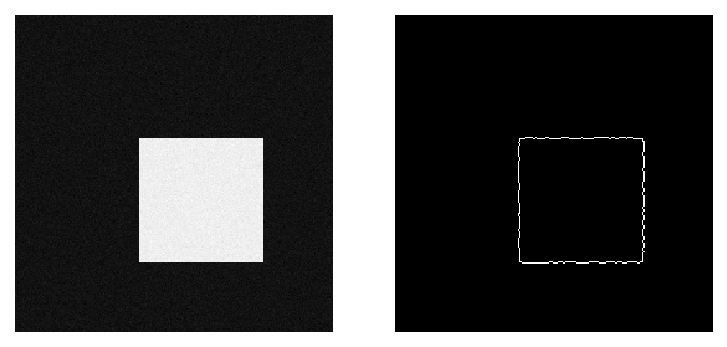

In [14]:
skimage_canny = feature.canny(image)
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(skimage_canny, cmap='gray')
plt.axis('off')
plt.show()


Celem laboratorium jest samodzielna implementacja przedstawionego algorytmu.
Uwaga: wyniki mogą różnić się od przedstawionych powyżej w zależności od przyjętych założeń i wewnętrznej implementacji filtracji Gaussa oraz doboru progu dolnego po algorytmie Otsu.
Szkielet funkcji będzie wyglądać następująco:


In [15]:
#def canny(image, sigma=1.0):
   # """
   # 1) Dokonaj filtracji obrazu filtrem Gaussa o zadanej sigmie
   # 2) Wyznacz przybliżenie gradientu (jego magnitude oraz kąt) za pomocą filtru Sobela
   # 3) Przeprowadź "non_maximum_supression" korzystając z magnitudy i kąta gradientu, wyznaczając tym samym potencjalnie krawędzie.
   # 4) Dokonaj podwójnego progowania potencjalnych krawędzi aby wyznaczyć krawędzie silne oraz krawędzie słabe.
   # 5) Przeproważ histerezę krawędzi, zwróć wynik.
   # """
   # edges = None
   # return None

Powyższa funkcja będzie się składać z następujących podfunkcji:

In [16]:
def gaussian_smoothing(image, sigma):
    
    size=2.54*sigma
    size=math.ceil(size)
    if(size%2==0):
        size=size+1
    a=size
    b=size
    gauss=np.zeros((a,b))
    a=a//2
    b=b//2
    for x in range(-a,a+1):
        for y in range(-b,b+1):
            c=sigma*(2*np.pi)**2
            d=np.exp(-(x**2+y**2)/(2*sigma**2))
            gauss[x+a,y+b]=(1/c)*d
    
    filtered=signal.convolve2d(image,gauss)
    return filtered


In [17]:
def calculate_gradients(image):
    gradient_magnitude = np.zeros(image.shape)
    gradient_angle = np.zeros(image.shape)
    
    #maska Sobela
    x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    y = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

    gx = signal.convolve2d(image, x, mode='same')
    gy = signal.convolve2d(image, y, mode='same')
    gradient_magnitude = np.sqrt((gx)**2+(gy)**2)
  
    for i in range(len(image)):
        for j in range(len(image[i])):
            if gx[i][j]==0:
                gradient_angle[i][j]=3.14/2
            else:
                gradient_angle[i][j]=np.arctan2(gy[i][j],gx[i][j])
                
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(gradient_magnitude,cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(gradient_angle,cmap='gray')
    plt.axis('off')
    
    return gradient_magnitude, gradient_angle

In [18]:
def non_maximum_supression(gradient_magnitude, gradient_angle):
    potential_edges = np.zeros(gradient_magnitude.shape)
    row,col = gradient_magnitude.shape
    gradient_angle=gradient_angle* 180./np.pi
    gradient_angle[gradient_angle<0]+=180
    
    for i in range(1,row-1):
        for j in range(1,col-1):
               
            if (0 <= gradient_angle[i,j] < 22.5) or (157.5 <= gradient_angle[i,j] <= 180): 
                a = gradient_magnitude[i,j+1]
                b = gradient_magnitude[i,j-1]
            elif (22.5 <= gradient_angle[i,j] < 67.5): 
                a = gradient_magnitude[i+1,j-1]
                b = gradient_magnitude[i-1,j+1]
            elif (67.5 <= gradient_angle[i,j] < 112.5): 
                a = gradient_magnitude[i+1,j]
                b = gradient_magnitude[i-1,j]
            elif (112.5 <= gradient_angle[i,j] < 157.5): 
                a = gradient_magnitude[i-1,j-1]
                b = gradient_magnitude[i+1,j+1]
                
            if (gradient_magnitude[i,j] >= a) and (gradient_magnitude[i,j] >= b):
                potential_edges[i,j] = gradient_magnitude[i,j]
            else:
                potential_edges[i,j] = 0
                
    return potential_edges


In [19]:
def otsu_threshold(image):
    image = image*256
    pixel_number = image.shape[0]*image.shape[1]
    mean = 1.0/pixel_number
    h,b = np.histogram(image,np.arange(0,257))
    threshold = -1
    last_value = -1
    intense = np.arange(256)
    for i in b[1:-1]:
        a = np.sum(h[:i])
        b = np.sum(h[i:])
        
        c = a*mean
        d = b*mean
        
        e = np.sum(intense[:i]*h[:i])/a
        f = np.sum(intense[i:]*h[i:])/b
        value = c*d*(e-f)**2
        
        if value>last_value:
            threshold = i
            last_value = value
    return threshold/256
   
       

def double_threshold(potential_edges, gradient_magnitude):
    strong_edges = np.zeros(gradient_magnitude.shape)
    weak_edges = np.zeros(gradient_magnitude.shape)
    high_threshold = otsu_threshold(gradient_magnitude)
    low_threshold = high_threshold/3
    
    x, y = potential_edges.shape
    sx, sy = np.where(potential_edges >= high_threshold)
    zx, zy = np.where(potential_edges < low_threshold)
    wx, wy = np.where((potential_edges <= high_threshold) & (potential_edges >= low_threshold))
    weak_edges[wx,wy] = 1
    strong_edges[sx,sy] = 1
    
    return strong_edges, weak_edges

In [20]:
def edge_hysteresis(strong_edges, weak_edges):
    edges = np.zeros(strong_edges.shape)
    edges = edges+strong_edges
    pixel_queue = queue.Queue() 
    visited = set() 
    for i in range(len(strong_edges)):
        for j in range(len(strong_edges[i])):
            if strong_edges[i][j] == 1:
                pixel_queue.put((i,j))
            else: continue
    
    def get_neighbours(i, j):
        neighbours = []
        for x in [i-1,i,i+1]:
            for y in [j-1,j,j+1]:
                if x in range(0,len(strong_edges)-1) and y in range(0,len(strong_edges[x]-1)) and (x,y) != (i,j):
                    neighbours.append((x,y))
        return neighbours
    
    while not pixel_queue.empty(): 
        pixel = pixel_queue.get()
        x = pixel[0]
        y = pixel[1]
        neighbours = get_neighbours(x,y)
        for every in neighbours:
            if weak_edges[every] == 1:
                edges[every[0], every[1]] = 1
                if not every in visited:
                    pixel_queue.put((every))
                visited.add((every))
    
    return edges

Finalnie korzystając z powyższych funkcji zaimplementuj funkcję canny:

In [23]:
def canny(image, sigma=1.0):
    
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.imshow(image,cmap='gray')
    plt.title("Obraz oryginalny")
    plt.axis('off')
    
    filtered = gaussian_smoothing(image, sigma)
    plt.subplot(1,2,2)
    plt.imshow(filtered,cmap='gray')
    plt.title("Obraz przefiltrowany")
    plt.axis('off')
    
    gradient, angle = calculate_gradients(filtered)
    plt.figure(2)
    plt.subplot(1,2,1)
    plt.imshow(gradient,cmap='gray')
    plt.title("Gradient")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(angle,cmap='gray')
    plt.title("Kąt")
    plt.axis('off')
    
    potential_edges = non_maximum_supression(gradient, angle)
    plt.figure(3)
    plt.imshow(potential_edges,cmap='gray')
    plt.title("Potential edges")
    plt.axis('off')
    
    threshold = otsu_threshold(image)
    strong,weak = double_threshold(potential_edges,gradient)
    plt.figure(4)
    plt.imshow(strong,cmap='gray')
    plt.title("Strong edges")
    plt.axis('off')
    plt.figure(5)
    plt.imshow(weak,cmap='gray')
    plt.title("Weak edges")
    plt.axis('off')
    
    edges = edge_hysteresis(strong, weak)
    plt.figure(6)
    plt.imshow(edges,cmap='gray')
    plt.title("Canny edges")
    plt.axis('off')
    return edges

Porównaj działanie zaimplementowanej funkcji na wygenerowanym oraz wczytanym obrazie:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in longlong_scalars


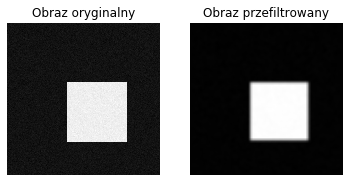

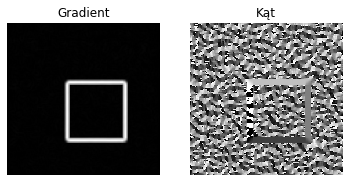

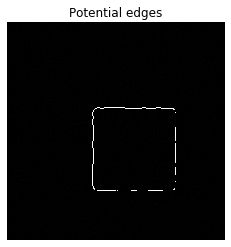

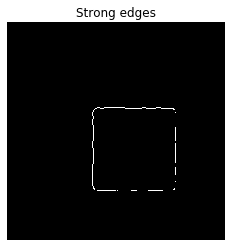

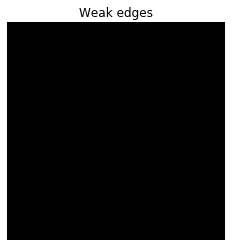

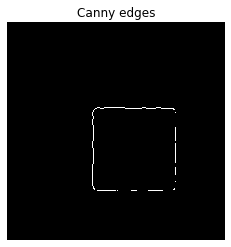

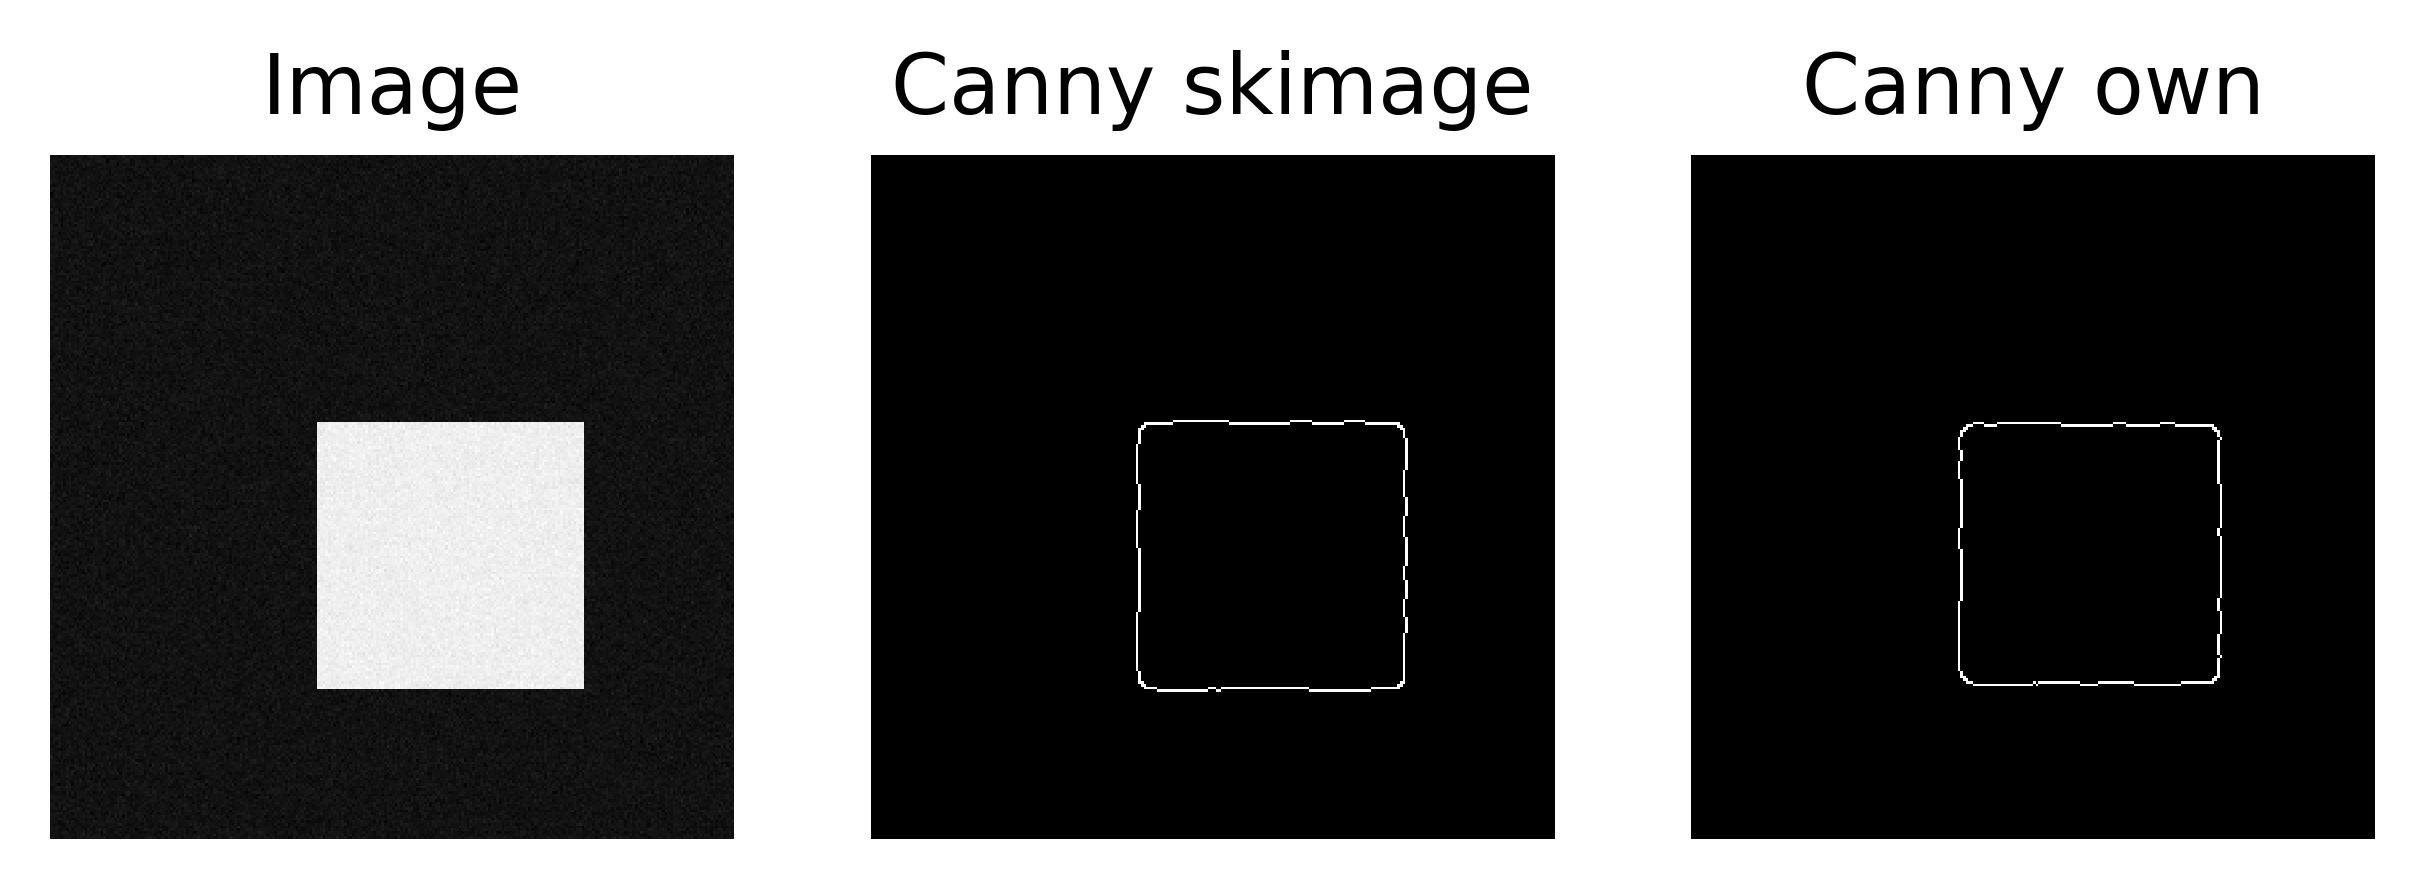

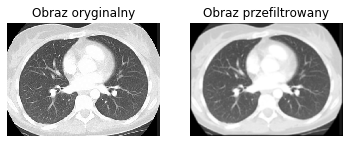

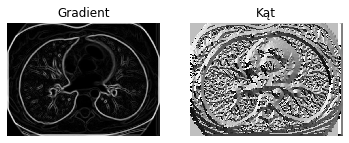

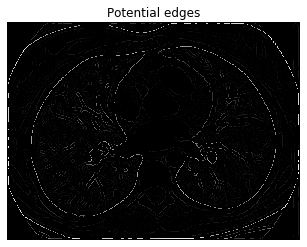

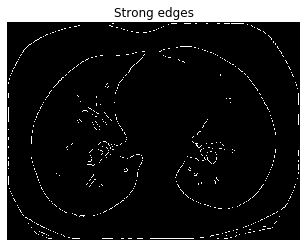

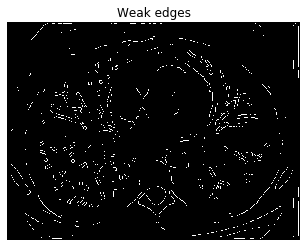

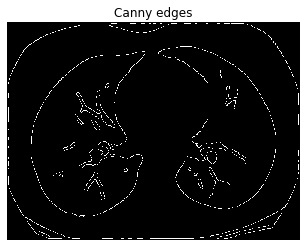

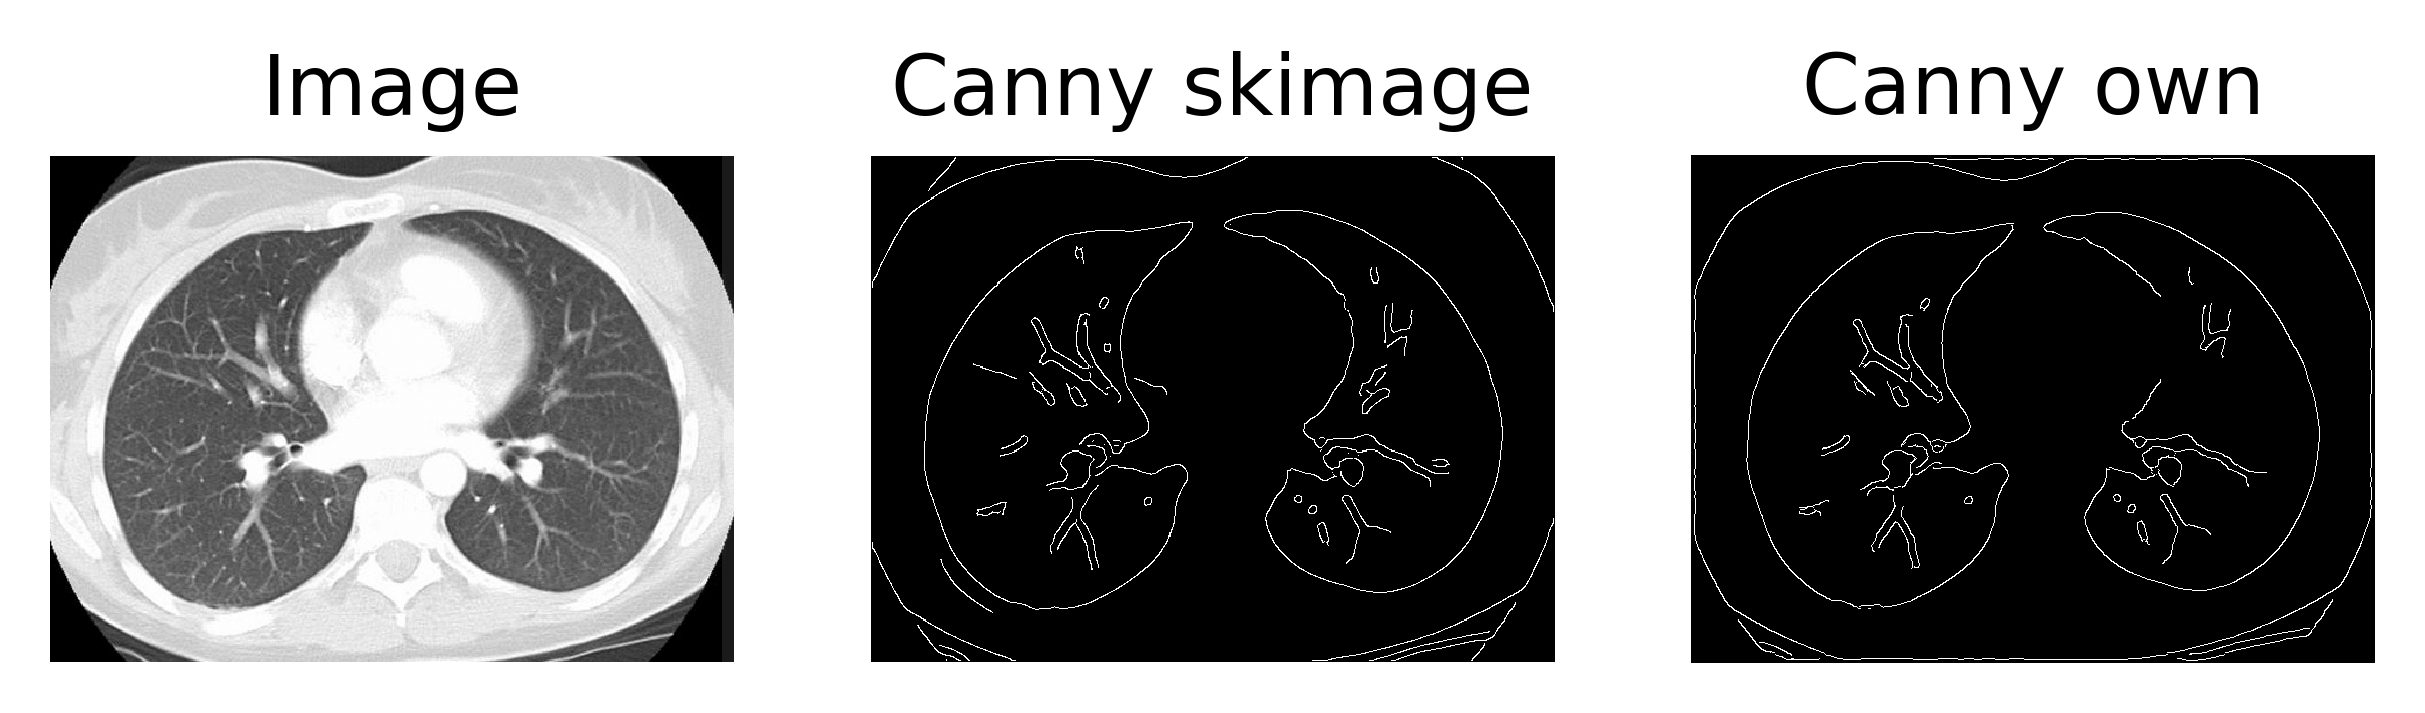

In [24]:
images = [image, color.rgb2gray(io.imread("CT_Lungs.png"))] 
# Krawędzie mają grubość jednego pixela, nie wszystkie muszą być widoczne (ustawienia wyświetlania). Aby zobaczyć wszystkie krawędzie zwiększ dpi rysunku.
for current_image in images:
    skimage_canny = feature.canny(current_image, sigma=3)
    own_canny = canny(current_image, sigma=3)
    plt.figure(dpi=500)
    plt.subplot(1, 3, 1)
    plt.imshow(current_image, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(skimage_canny, cmap='gray')
    plt.title("Canny skimage")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(own_canny, cmap='gray')
    plt.title("Canny own")
    plt.axis('off')
    plt.show()